In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install --upgrade protobuf==3.20.3 --quiet
!pip install --upgrade umap-learn==0.5.5 --quiet
!pip install --upgrade scikit-learn==1.3.2 --quiet

import os, signal
os.kill(os.getpid(), signal.SIGKILL)  # kernel restart


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

In [2]:
import os, time, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"


In [4]:
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.8,0.8,0.8,0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [5]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=TwoCropsTransform(simclr_transform))

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Train samples: 812
Test samples: 204


In [6]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, out_dim=128):
        super().__init__()
        self.encoder = base_encoder
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()

        self.proj = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.proj(h)
        return F.normalize(z, dim=1)

resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model = SimCLR(resnet50).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


In [7]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)                 # (2N, D)
    sim = torch.mm(z, z.t()) / temperature           # (2N, 2N)

    mask = torch.eye(2*N, device=z.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, -1e9)                # mask self similarity

    targets = torch.arange(2*N, device=z.device)
    targets = (targets + N) % (2*N)                  # positive pair index

    return F.cross_entropy(sim, targets)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
epochs = 50
loss_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for (xi, xj), _ in train_loader:
        xi, xj = xi.to(device), xj.to(device)

        zi = model(xi)
        zj = model(xj)

        loss = nt_xent_loss(zi, zj, temperature=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f}")

torch.save(model.encoder.state_dict(), "frozen_encoder.pt")


Epoch 1/50 Loss: 4.0563
Epoch 2/50 Loss: 3.6711
Epoch 3/50 Loss: 3.6066
Epoch 4/50 Loss: 3.5487
Epoch 5/50 Loss: 3.5066
Epoch 6/50 Loss: 3.5365
Epoch 7/50 Loss: 3.4742
Epoch 8/50 Loss: 3.4753
Epoch 9/50 Loss: 3.5012
Epoch 10/50 Loss: 3.4591
Epoch 11/50 Loss: 3.3942
Epoch 12/50 Loss: 3.4338
Epoch 13/50 Loss: 3.4207
Epoch 14/50 Loss: 3.4146
Epoch 15/50 Loss: 3.4148
Epoch 16/50 Loss: 3.4032
Epoch 17/50 Loss: 3.4064
Epoch 18/50 Loss: 3.3797
Epoch 19/50 Loss: 3.3924
Epoch 20/50 Loss: 3.4106
Epoch 21/50 Loss: 3.3841
Epoch 22/50 Loss: 3.4040
Epoch 23/50 Loss: 3.3667
Epoch 24/50 Loss: 3.3670
Epoch 25/50 Loss: 3.3849
Epoch 26/50 Loss: 3.3531
Epoch 27/50 Loss: 3.3674
Epoch 28/50 Loss: 3.3313
Epoch 29/50 Loss: 3.3520
Epoch 30/50 Loss: 3.3441
Epoch 31/50 Loss: 3.3100
Epoch 32/50 Loss: 3.3540
Epoch 33/50 Loss: 3.3370
Epoch 34/50 Loss: 3.3505
Epoch 35/50 Loss: 3.3276
Epoch 36/50 Loss: 3.3199
Epoch 37/50 Loss: 3.3302
Epoch 38/50 Loss: 3.3386
Epoch 39/50 Loss: 3.3231
Epoch 40/50 Loss: 3.3431
Epoch 41/

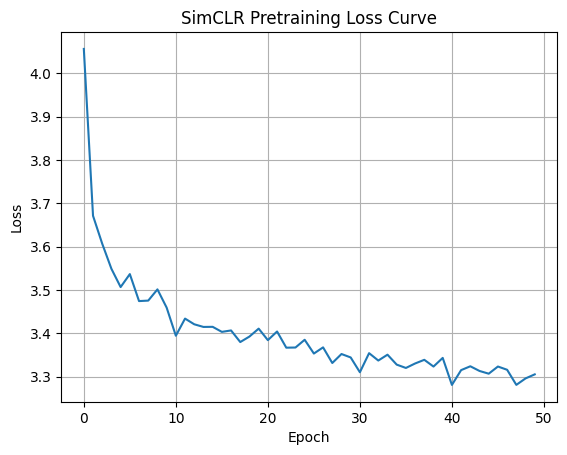

In [9]:
plt.plot(loss_history)
plt.title("SimCLR Pretraining Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [10]:
for p in model.encoder.parameters():
    p.requires_grad = False


In [11]:
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

probe_full = datasets.ImageFolder(DATA_DIR, transform=eval_transform)
train_probe, test_probe = random_split(probe_full, [train_size, test_size])

train_loader_probe = DataLoader(train_probe, batch_size=64, shuffle=False, num_workers=2)
test_loader_probe  = DataLoader(test_probe, batch_size=64, shuffle=False, num_workers=2)


In [12]:
def extract_features(loader):
    model.encoder.eval()
    feats, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            f = model.encoder(imgs).cpu()
            feats.append(f)
            labels.append(lbls)
    return torch.cat(feats).numpy(), torch.cat(labels).numpy()

X_train, y_train = extract_features(train_loader_probe)
X_test, y_test   = extract_features(test_loader_probe)

print("Feature shape:", X_train.shape)


Feature shape: (812, 2048)


In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver="saga", multi_class="multinomial")
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6764705882352942
[[ 0  1  0  0  0  0  0  0  0  0]
 [ 0 22  0  0  0  1  0  0  1  0]
 [ 0  0 16  3  1  0  2  0  0  0]
 [ 0  0  1 12  1  4  1  0  1  1]
 [ 0  0  3  0 27  5  0  0  0  1]
 [ 0  1  2  4  3 32  7  0  0  1]
 [ 0  1  2  5  1  3 10  0  0  1]
 [ 0  0  0  0  0  0  0  4  2  0]
 [ 0  0  0  0  0  0  0  0  6  0]
 [ 0  0  1  1  2  1  0  1  0  9]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.88      0.92      0.90        24
           2       0.64      0.73      0.68        22
           4       0.48      0.57      0.52        21
           5       0.77      0.75      0.76        36
           6       0.70      0.64      0.67        50
           7       0.50      0.43      0.47        23
           8       0.80      0.67      0.73         6
           9       0.60      1.00      0.75         6
          10       0.69      0.60      0.64        15

    accuracy                           0.68 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
import numpy as np

X_emb = np.concatenate([X_train, X_test], axis=0)
y_emb = np.concatenate([y_train, y_test], axis=0)

print("X_emb:", X_emb.shape, "y_emb:", y_emb.shape)


X_emb: (1016, 2048) y_emb: (1016,)


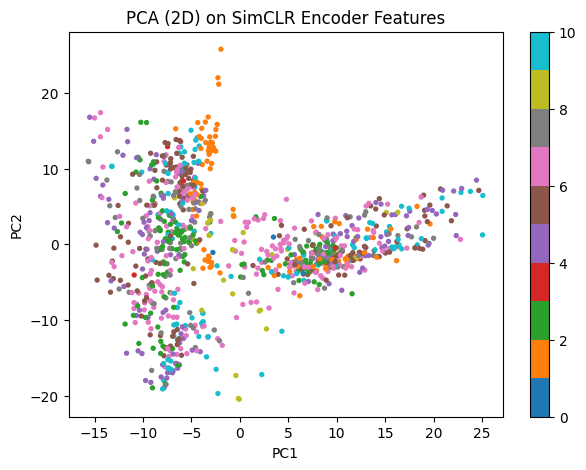

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
pca_res = pca.fit_transform(X_emb)

plt.figure(figsize=(7,5))
plt.scatter(pca_res[:,0], pca_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("PCA (2D) on SimCLR Encoder Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()


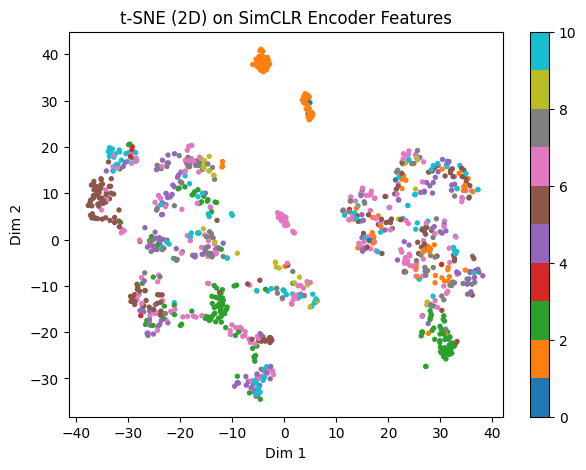

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

tsne_res = tsne.fit_transform(X_emb)

plt.figure(figsize=(7,5))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("t-SNE (2D) on SimCLR Encoder Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar()
plt.show()


2025-12-13 20:07:04.930356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765656425.099638     115 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765656425.147604     115 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


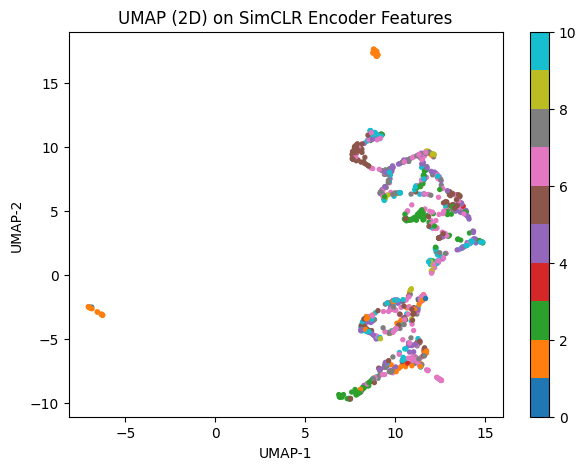

In [17]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

um = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

um_res = um.fit_transform(X_emb)

plt.figure(figsize=(7,5))
plt.scatter(um_res[:,0], um_res[:,1], c=y_emb, s=8, cmap="tab10")
plt.title("UMAP (2D) on SimCLR Encoder Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar()
plt.show()


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

X_scaled = StandardScaler().fit_transform(X_emb)

sil = silhouette_score(X_scaled, y_emb, metric="euclidean")
print("Silhouette Score (scaled features):", sil)


Silhouette Score (scaled features): -0.042351052


In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for k in [1, 5, 10, 20]:
    knn = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    )
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    print(f"k={k} Accuracy:", accuracy_score(y_test, pred))


k=1 Accuracy: 0.5490196078431373
k=5 Accuracy: 0.5392156862745098
k=10 Accuracy: 0.4803921568627451
k=20 Accuracy: 0.4803921568627451


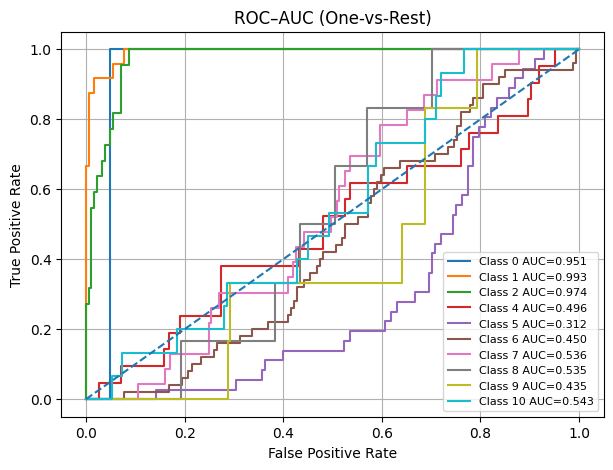

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Use the trained 'clf' from Cell 13 (pipeline)
y_scores = clf.predict_proba(X_test)

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(7,5))
for idx, cls in enumerate(classes):
    # skip class if it doesn't appear in y_test
    if y_test_bin[:, idx].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_test_bin[:, idx], y_scores[:, idx])
    plt.plot(fpr, tpr, label=f"Class {cls} AUC={auc(fpr,tpr):.3f}")

plt.plot([0,1],[0,1],'--')
plt.title("ROC–AUC (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


In [21]:
!pip install thop -q
from thop import profile

dummy = torch.randn(1, 3, 224, 224).to(device)
macs, params = profile(model.encoder, inputs=(dummy,), verbose=False)

print("GFLOPs:", macs/1e9)
print("Params (M):", params/1e6)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

1% labels → Accuracy: 0.0980
5% labels → Accuracy: 0.3824
10% labels → Accuracy: 0.4559
25% labels → Accuracy: 0.5441
50% labels → Accuracy: 0.5833
100% labels → Accuracy: 0.6765


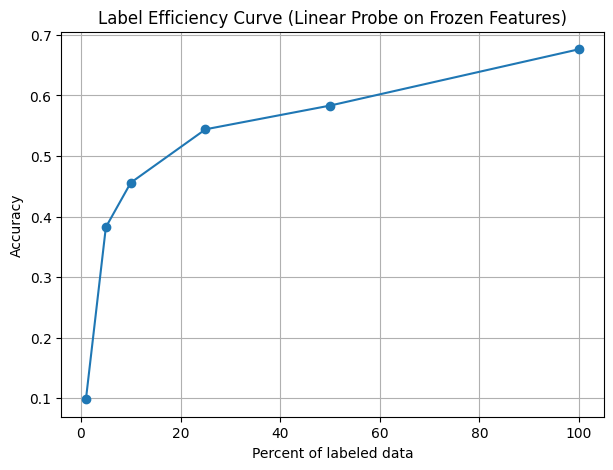

In [23]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

ratios = [0.01, 0.05, 0.10, 0.25, 0.50, 1.00]
results = {}

X = X_train
y = y_train
classes = np.unique(y)

rng = np.random.default_rng(42)

for r in ratios:
    X_small, y_small = [], []

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        n_samples = max(1, int(len(cls_idx) * r))
        chosen = rng.choice(cls_idx, n_samples, replace=False)
        X_small.append(X[chosen])
        y_small.append(y[chosen])

    X_small = np.vstack(X_small)
    y_small = np.hstack(y_small)

    clf_eff = make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=5000, solver="saga", multi_class="multinomial")
    )
    clf_eff.fit(X_small, y_small)

    acc = clf_eff.score(X_test, y_test)
    results[r] = acc
    print(f"{int(r*100)}% labels → Accuracy: {acc:.4f}")

plt.figure(figsize=(7,5))
plt.plot([r*100 for r in ratios], [results[r] for r in ratios], marker="o")
plt.title("Label Efficiency Curve (Linear Probe on Frozen Features)")
plt.xlabel("Percent of labeled data")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [26]:
import time

start = time.time()
clf_time = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver="saga", multi_class="multinomial")
)
clf_time.fit(X_train, y_train)
train_time = time.time() - start

start = time.time()
_ = clf_time.predict(X_test)
test_time = time.time() - start

print("Train Time (s):", train_time)
print("Test Time (s):", test_time)


Train Time (s): 311.3935375213623
Test Time (s): 0.00467991828918457
